In [2]:
# System and Core Libraries
from pathlib import Path
import pandas as pd
import numpy as np
from functools import partial
# Visualization
import seaborn as sns

import math
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from tqdm import trange

import numpy as np
from experiments_util import calc_eps
from rdm.util import COLORS

N = 10_000_000

knn = 18
GS = 2 / knn
n_queries = 1000
sample_rate=1/100
sigma=0.2
delta = 1/N 
eps, opt_alpha = calc_eps(sigma, sample_rate, knn, n_queries, delta=delta)
print(
    f"\n\tSampling rate = {100 * sample_rate:.3g}%,"
    f"\n\t Sigma = {sigma},"
    f"\n\tIterated over {n_queries} steps,\nsatisfies "
    f"Differential Privacy with\n\tepsilon = {eps:.3g},"
    f"\n\tdelta = {delta}."
    f"\nThe optimal alpha is {opt_alpha}."
)
print(f'Epsilon: {eps}, alpha: {opt_alpha}')



	Sampling rate = 1%,
	 Sigma = 0.2,
	Iterated over 1000 steps,
satisfies Differential Privacy with
	epsilon = 0.997,
	delta = 1e-07.
The optimal alpha is 25.0.
Epsilon: 0.9968787608646338, alpha: 25.0


In [27]:
def min_epsilon(r, N):
    min_q = 1 / (r * N)
    sample_rates = np.power(10, np.arange(math.log10(min_q), 1e-4, 0.01))
    epsilons = np.zeros(len(sample_rates))
    for i in range(len(sample_rates)):
        sample_rate = min(sample_rates[i], 1.0)
        knn = r * N * sample_rate
        epsilons[i], _ = calc_eps(sigma, sample_rate, knn, n_queries, delta=delta)
    return epsilons.min()

report_min_epsilons = {}

densities = np.power(10, np.arange(-6, -1.999, 0.25))
for key, N in [('1M', 1_000_000), ('10M', 10_000_000), ('100M', 100_000_000)]:
    min_epsilons = np.zeros(len(densities))
    for i in trange(len(densities)):
        r = densities[i]
        min_epsilons[i] = min_epsilon(r, N)
    report_min_epsilons[key] = min_epsilons

  0%|          | 0/17 [00:00<?, ?it/s]

/private/home/lebensold/anaconda3/envs/rdmfaiss_17/lib/python3.9/site-packages/opacus/accountants/analysis/rdp.py:332: UserWarning: Optimal order is the smallest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
 88%|████████▊ | 15/17 [02:56<00:22, 11.10s/it]/private/home/lebensold/anaconda3/envs/rdmfaiss_17/lib/python3.9/site-packages/opacus/accountants/analysis/rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
100%|██████████| 17/17 [02:55<00:00, 10.35s/it]


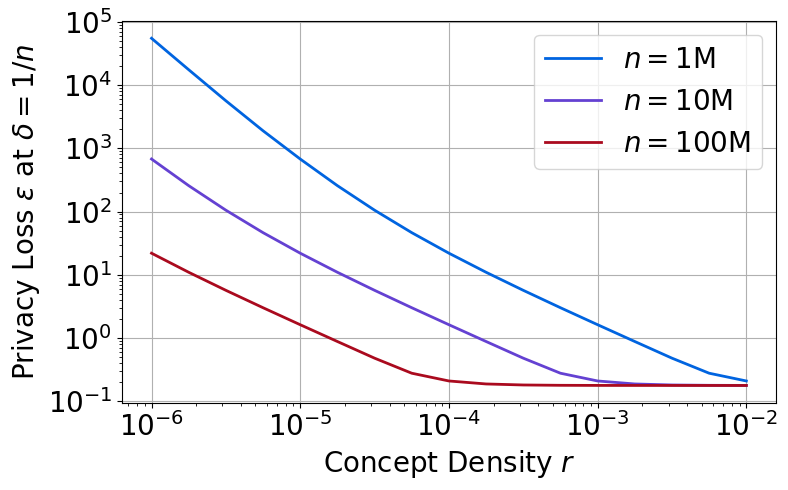

In [28]:

plt.figure(figsize=(8,5))
plt.plot(densities, report_min_epsilons['1M'], linewidth=2, color=COLORS['bluemeta'], label="$n=1$M")
plt.plot(densities, report_min_epsilons['10M'], linewidth=2, color=COLORS['purple'], label="$n=10$M")
plt.plot(densities, report_min_epsilons['100M'], linewidth=2, color=COLORS['red'], label="$n=100$M")
plt.xlabel('Concept Density $r$', fontsize=20)
plt.ylabel('Privacy Loss $\epsilon$ at $\delta=1/n$', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xscale('log')
plt.yscale('log')
plt.grid('on', which="major")
plt.legend(fontsize=20)
plt.tight_layout()

/private/home/lebensold/anaconda3/envs/rdmfaiss_17/lib/python3.9/site-packages/opacus/accountants/analysis/rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(


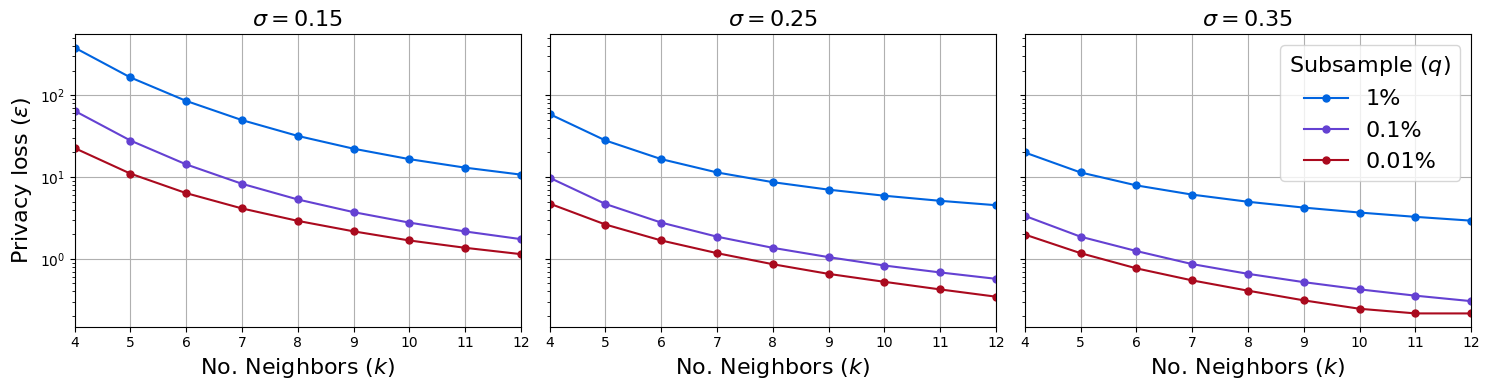

In [32]:
colors = [COLORS['bluemeta'], COLORS['purple'], COLORS['red']]

N = 100_000_000
sigmas = [0.05, 0.15, 0.25]
sample_rates = [1/100, 1/1000, 1/10000]
k_nns = [4, 5, 6, 7, 8, 9, 10, 11, 12]
delta = 1/N
n_query_list = [10_000]
delta = 1/N

sigmas = [0.15, 0.25, 0.35]
fig, axs = plt.subplots(len(n_query_list), len(sigmas), sharey=True, figsize=(15, 4))

for row, n_queries in enumerate(n_query_list):
    for idx, sigma in enumerate(sigmas):
        ax = axs[row, idx] if len(n_query_list) > 1 else axs[idx]
        
        for jdx, sample_rate in enumerate(sample_rates):
            xs = k_nns
            ys = [calc_eps(sigma, sample_rate, k, n_queries, delta=delta)[0] for k in k_nns]
            ax.set_title(f'$\sigma ={sigma}$', fontsize=16)
            ax.plot(xs, ys, label=f'{100 * sample_rate:.3g}%', c=colors[jdx], markersize=10, marker='.')
        if idx == 0:
            ax.set_ylabel('Privacy loss ($\epsilon$)',fontsize=16)
        ax.set_xlabel('No. Neighbors ($k$)', fontsize=16)
        ax.set_xlim(4,12)
        ax.set_yscale('log')
        ax.grid()
        if idx == len(sigmas) - 1 and row == 0:
            ax.legend(fontsize=16, title="Subsample ($q$)", title_fontsize=16)
fig.tight_layout()